# ML Project

Load libraries, and data sets to workbook

In [1]:
import pandas as pd
import numpy as np
import re
import pylab 
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline



from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV,  BayesianRidge
import statsmodels.api as sm
from scipy import stats

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split




In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
pd.set_option("display.max_columns", 100)
print("Number of Rows:", df_train.shape[0])
print("Number of Columns:", df_train.shape[1])
print("-" * 30)


Number of Rows: 1460
Number of Columns: 81
------------------------------


# Data Exploration and Pre-Processing

## Check for NaN values and how to deal with them

`Luana:` Created "Total.Nans" column and changed the name of "total.Nans" column to "Percent.Nans"

In [4]:
def get_Nan(dataframe):
    total_nans=dataframe.isnull().sum().sum()
    print('Total Number of NaNs:')
    print(total_nans)
    print('-'*80)
    
    percent_nans=(total_nans/(dataframe.shape[0]*dataframe.shape[1]))*100
    print('Percentage of NaNs in total data:')
    print("%.2f" %percent_nans)
    print('-'*80)

    print('Number of NaNs per column')
    #Pre-processing steps
    col_nan=pd.DataFrame(dataframe.isnull().sum())
    col_nan=col_nan.reset_index()
    col_nan=col_nan.rename(columns={'index':'column', 0:'Percent.Nans'})
    col_nan['Number.Nans']=col_nan['Percent.Nans']
    #convert to percentage of NaN's per row
    col_nan['Percent.Nans']=(col_nan['Percent.Nans']/len(dataframe))*100
    return (round(col_nan.sort_values(by='Percent.Nans', ascending=False).loc[(col_nan['Percent.Nans'])>0],ndigits=2))        
        

get_Nan(df_train)

Total Number of NaNs:
6965
--------------------------------------------------------------------------------
Percentage of NaNs in total data:
5.89
--------------------------------------------------------------------------------
Number of NaNs per column


,column,Percent.Nans,Number.Nans
72,PoolQC,99.52,1453
74,MiscFeature,96.30,1406
6,Alley,93.77,1369
73,Fence,80.75,1179
57,FireplaceQu,47.26,690
3,LotFrontage,17.74,259
59,GarageYrBlt,5.55,81
64,GarageCond,5.55,81
58,GarageType,5.55,81
60,GarageFinish,5.55,81


### Fill NAs according to the data description

In [5]:
def prepare_data(dataframe):
    
    # Fill Na of PoolQC with 'NoPool' because in description text Na means that there is no pool
    dataframe['PoolQC']=dataframe['PoolQC'].fillna('NoPool')
    
    # Check MiscFeature, in description text Na means there are no extra features so Na will be replaced with 'None'
    dataframe['MiscFeature']=dataframe['MiscFeature'].fillna('None')

    # Check Alley column, in description text Na means there is no alley access, Na will be replaced with 'NoAccess'
    dataframe['Alley']=dataframe['Alley'].fillna('NoAccess')

    # Check Fence column, in description text Na means no fence, Na will be replaced with 'NoFence'
    dataframe['Fence']=dataframe['Fence'].fillna('NoFence')

    # Check Fireplace column, in description text Na means no fireplace, Na will be replaced with 'NoFireplace'
    dataframe['FireplaceQu']=dataframe['FireplaceQu'].fillna('NoFireplace')

    # Check GarageQual, in description text Na means no garage, Na will be replaced with "NoGarage"
    dataframe['GarageQual']=dataframe['GarageQual'].fillna('NoGarage')

    # Check BsmtExposure, in description text Na means no basement, Na will be replaced with "NoBasement"
    dataframe['BsmtExposure']=dataframe['BsmtExposure'].fillna('NoBasement')

    # Check BsmtFinType2, in description text Na means no basement, Na will be replaced with "NoBasement"
    dataframe['BsmtFinType2']=dataframe['BsmtFinType2'].fillna('NoBasement')

    # Check BsmtFinType1, in description text Na means no basement, Na will be replaced with "NoBasement"
    dataframe['BsmtFinType1']=dataframe['BsmtFinType1'].fillna('NoBasement')

    # Check BsmtCond, in description text Na means no basement, Na will be replaced with "NoBasement"
    dataframe['BsmtCond']=dataframe['BsmtCond'].fillna('NoBasement')

    # Check BsmtQual, in description text Na means no basement, Na will be replaced with "NoBasement"
    dataframe['BsmtQual']=dataframe['BsmtQual'].fillna('NoBasement')

    # Checking the empty values for the garage attribute, the empty values match with the rows that have Na's in the other columns. Therefore we can replace those calues with 'NoGarage'
    dataframe['GarageYrBlt']=dataframe['GarageYrBlt'].fillna(0)
    dataframe['GarageCond']=dataframe['GarageCond'].fillna('NoGarage')
    dataframe['GarageType']=dataframe['GarageType'].fillna('NoGarage')
    dataframe['GarageFinish']=dataframe['GarageFinish'].fillna('NoGarage')
    
    #Define plotting functions that use variables as responses
    dataframe['HouseAge'] = dataframe.YrSold - dataframe.YearRemodAdd
    dataframe['Vintage'] = dataframe.YrSold - dataframe.YearBuilt
    dataframe['HouseAge'] = [0 if x < 0 else x for x in dataframe.HouseAge]
    dataframe['OutdoorArea'] = dataframe.PoolArea + dataframe.WoodDeckSF + dataframe.OpenPorchSF + dataframe.ScreenPorch + dataframe['3SsnPorch'] + dataframe.EnclosedPorch
    dataframe['TotalBath'] = dataframe.FullBath + dataframe.BsmtFullBath
    dataframe['TotalLvArea'] = dataframe.GrLivArea + dataframe.TotalBsmtSF# + dataframe.OutdoorArea
    dataframe['TotalArea'] = dataframe.OutdoorArea + dataframe.GrLivArea + dataframe.TotalBsmtSF + dataframe.GarageArea
    
    #Creating LotShape2, PoolQC2 and Fireplaces2 as binary variables for existing features
    dataframe['LotShapeBin'] = ['Reg' if x == 'Reg' else 'IR' for x in dataframe.LotShape]
    dataframe['PoolBin'] = ['No' if x == 'NoPool' else 'Yes' for x in dataframe.PoolQC]
    dataframe['FireplacesBin'] = ['No' if x == 0 else 'Yes' for x in dataframe.Fireplaces]
    
    dataframe['YearBuilt2'] = ['No' if x == 0 else 'Yes' for x in dataframe.Fireplaces]
    
    dataframe['SqrtLotArea']=np.sqrt(dataframe['LotArea'])
    cond = dataframe['LotFrontage'].isnull()
    dataframe.LotFrontage[cond]=dataframe.SqrtLotArea[cond]


    

Checking the empty values for the garage year built, the empty values match with the rows that have Na's in the other columns. Therefore we can replace those values with 'NoGarage'

In [6]:
print("Unique Garage Types for GarageYrBlt = NA:", df_train[df_train["GarageYrBlt"].isna()]["GarageType"].unique())

Unique Garage Types for GarageYrBlt = NA: [nan]


In [7]:
prepare_data(df_train)
prepare_data(df_test)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To work with different type of analysis:
 - LotFrontage
 - MasVnrArea
 - MasVnrType
 - Electrical

In [8]:
get_Nan(df_train)

Total Number of NaNs:
17
--------------------------------------------------------------------------------
Percentage of NaNs in total data:
0.01
--------------------------------------------------------------------------------
Number of NaNs per column


,column,Percent.Nans,Number.Nans
25,MasVnrType,0.55,8
26,MasVnrArea,0.55,8
42,Electrical,0.07,1


In [9]:
#df_train = df_train[pd.notnull(df_train["LotFrontage"])]
df_train = df_train[pd.notnull(df_train["MasVnrType"])]
df_train = df_train[pd.notnull(df_train["MasVnrArea"])]
df_train = df_train[pd.notnull(df_train["Electrical"])]
                #we have only one missing observation in electrical, we can  probably just delete this row
get_Nan(df_train)

Total Number of NaNs:
0
--------------------------------------------------------------------------------
Percentage of NaNs in total data:
0.00
--------------------------------------------------------------------------------
Number of NaNs per column


,column,Percent.Nans,Number.Nans


# Exploratory Data Analysis (EDA)

## Sale Price

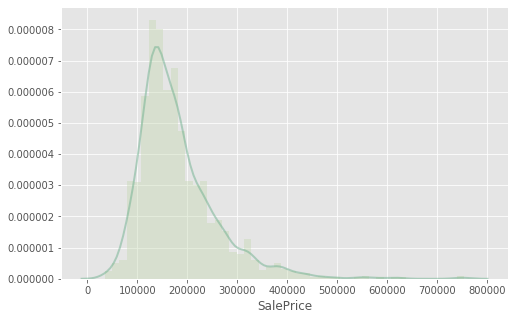

In [10]:
plt.figure(figsize = (8,5))
ax = sns.distplot(df_train["SalePrice"], color = [0.7622812227381776, 0.8406850963511671, 0.6846482959871109],
                  norm_hist=True, kde_kws={"color": [0.43556021358837316, 0.6909549473725914, 0.560621060036929],
                      "alpha":0.5, "linewidth": 2, "shade":False })
# xx = np.arange(0, 5000, 10)
# yy = stats.norm.pdf(xx)
# ax.plot(xx, yy, 'r', lw=2)
plt.show()

In [11]:
print('Skewness: %.4f' %df_train["SalePrice"].skew())

Skewness: 1.8831


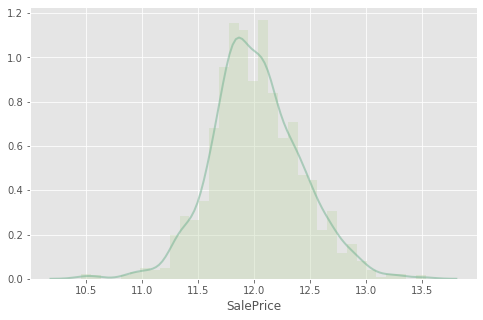

In [12]:
plt.figure(figsize = (8,5))
sns.distplot(np.log(df_train["SalePrice"]), color = [0.7622812227381776, 0.8406850963511671, 0.6846482959871109],
             norm_hist=True,
             kde_kws={"color": [0.43556021358837316, 0.6909549473725914, 0.560621060036929],
                      "alpha":0.5, "linewidth": 2, "shade":False })
plt.show()

In [13]:
print('Skewness: %.4f' %np.log(df_train["SalePrice"]).skew())

Skewness: 0.1219


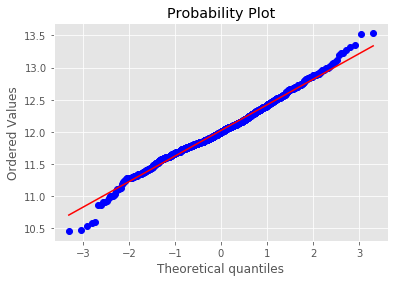

In [14]:
stats.probplot(np.log(df_train["SalePrice"]), dist="norm", plot=pylab, fit = False)
pylab.show()

## Correlations

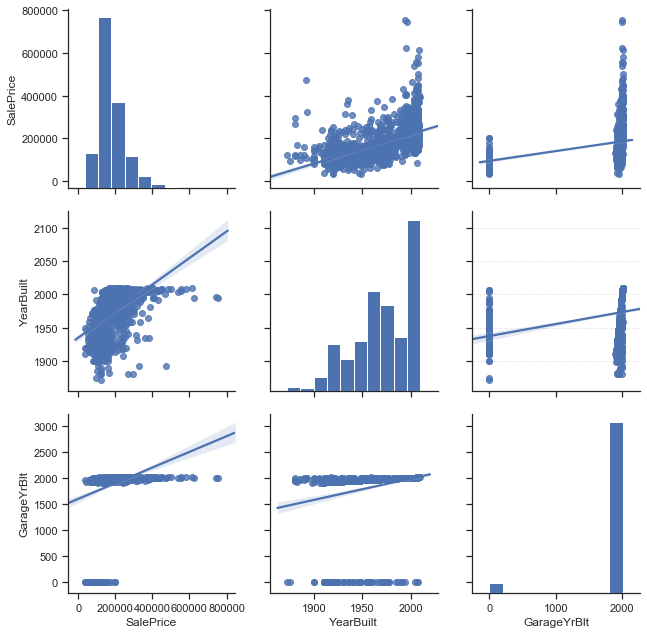

In [15]:
sns.set(style="ticks", color_codes=True)
cols = ['SalePrice', 'YearBuilt', 'GarageYrBlt'] #Change to test different variables

sns.pairplot(df_train[cols], height = 3.0, kind="reg")
plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.2, axis = "y")
plt.show()

In [16]:
colcor = [
    #'Id',
 #'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 #'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 #'Condition1',
 #'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 #'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 #'RoofMatl',
 'Exterior1st',
 #'Exterior2nd',
 'MasVnrType',
 #'MasVnrArea',
 'ExterQual',
 #'ExterCond',
 'Foundation',
 'BsmtQual',
 #'BsmtCond',
 'BsmtExposure',
 #'BsmtFinType1',
 #'BsmtFinSF1',
 #'BsmtFinType2',
 #'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 #'Electrical',
 #'1stFlrSF',
 #'2ndFlrSF',
 #'LowQualFinSF',
 'GrLivArea',
 #'BsmtFullBath',
 #'BsmtHalfBath',
 #'FullBath',
 #'HalfBath',
 'BedroomAbvGr',
 #'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 #'Functional',
 #'Fireplaces',
 'FireplaceQu',
 #'GarageType',
 'GarageYrBlt',
 #'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 #'GarageCond',
 'PavedDrive',
 #'WoodDeckSF',
 #'OpenPorchSF',
 #'EnclosedPorch',
 #'3SsnPorch',
 #'ScreenPorch',
 'PoolArea',
 #'PoolQC',
 #'Fence',
 #'MiscFeature',
 #'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'HouseAge',
 'Vintage',
 'OutdoorArea',
 'TotalBath',
 'LotShapeBin',
 'PoolBin',
 'FireplacesBin',
 #'YearBuilt2',
 #'SqrtLotArea',
 'TotalLvArea',
 'TotalArea',
 'SalePrice',
]

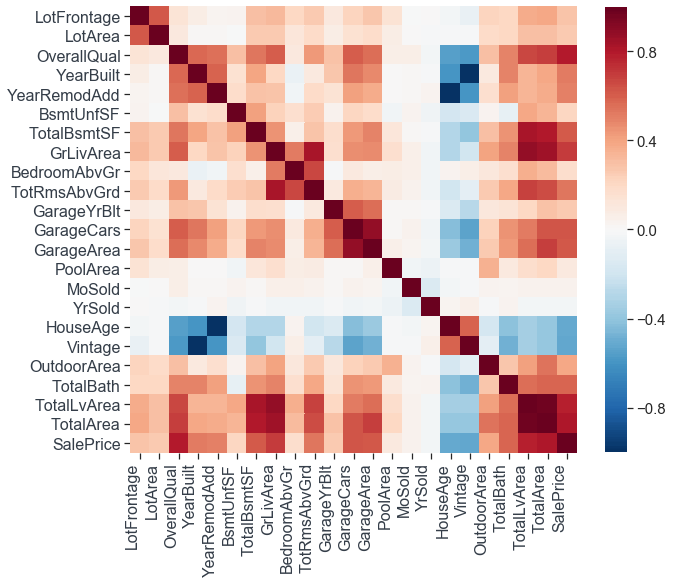

In [17]:
data = df_train[colcor]

corr = data.corr()

plt.figure(figsize = (10,10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=(sns.color_palette("RdBu_r", 200)),
    square=True,
    linewidth=0, cbar = True, cbar_kws={"shrink": 0.82}, xticklabels=1)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)


plt.yticks(ax.get_yticks(), fontsize = 16, color = '#343D48')
plt.xticks(ax.get_xticks(), fontsize = 16, color = '#343D48', rotation=90)

plt.show()


## Boxplots (categorical variables)

In [18]:
def boxplotpresentation (features):
    
    for elem in features:

        my_order = df_train.groupby(by=[elem])["SalePrice"].median().sort_values(ascending=False).iloc[::-1].index

        nobs = df_train[elem].value_counts().reindex(my_order).values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
                
        plt.figure(figsize = (15,6))
        sns.set(style="ticks", color_codes=True)
        ax = sns.boxplot(df_train[elem], df_train["SalePrice"]/1000,
                         showmeans = True,
                         palette = (sns.color_palette("RdBu_r", len(my_order))),
                         meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":'#FF0101'},
                         order = my_order)
        plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.2, axis = "y")
        sns.set_context(font_scale=1.2, rc={"lines.linewidth": 2.5})
        plt.yticks(ax.get_yticks(), fontsize = 15, color = '#343D48')
        plt.xticks(ax.get_xticks(), fontsize = 15, color = '#343D48')
        plt.xlabel(elem, fontsize = 16, color = '#343D48')
        plt.ylabel('Sale Price (K)', fontsize = 16, color = '#343D48')
        ax.set_ylim(-5,)
        
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick], 3, nobs[tick],
            horizontalalignment='center', size='medium', color='dimgrey', weight='semibold')
        

        
        plt.show()

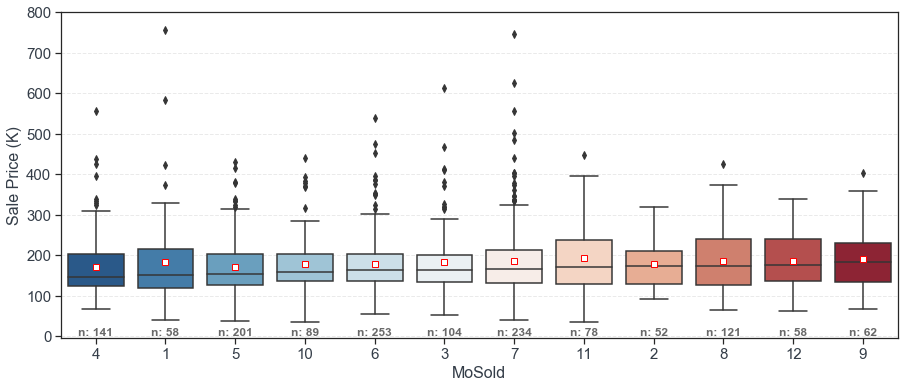

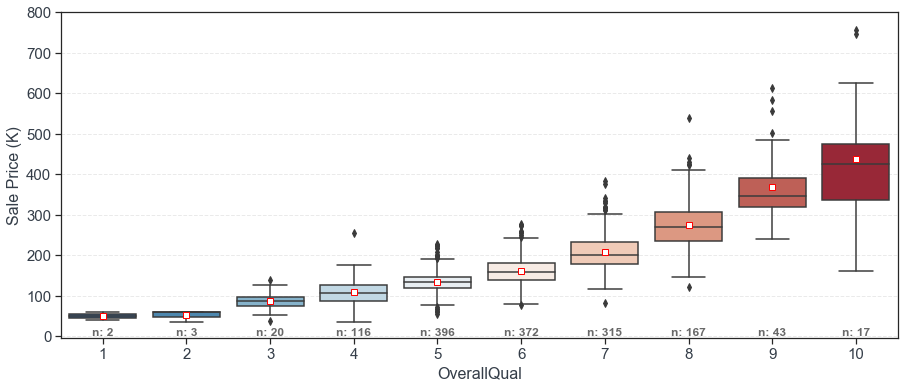

In [19]:
boxplotpresentation(['MoSold', 'OverallQual'])

In [20]:
def boxplot (features):
    
    for elem in features:

        my_order = df_train.groupby(by=[elem])["SalePrice"].median().sort_values(ascending=False).iloc[::-1].index

        nobs = df_train[elem].value_counts().reindex(my_order).values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
                
        plt.figure(figsize = (14,7))
        sns.set(style="ticks", color_codes=True)
        ax = sns.boxplot(df_train[elem], df_train["SalePrice"],
                         color = [0.7622812227381776, 0.8406850963511671, 0.6846482959871109], showmeans = True,
                         meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"darkgreen"},
                         order = my_order)
        plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.2, axis = "y")
        
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick], 5000, nobs[tick],
            horizontalalignment='center', size='x-small', color='dimgrey', weight='semibold')

        
        plt.show()

In [21]:
features = [
    #'Id',
 'MSSubClass',
 'MSZoning',
 #'LotFrontage',
 #'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 #'YearBuilt',
 #'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 #'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 #'BsmtFinSF1',
 'BsmtFinType2',
 #'BsmtFinSF2',
 #'BsmtUnfSF',
 #'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 #'1stFlrSF',
 #'2ndFlrSF',
 #'LowQualFinSF',
 #'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 #'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 #'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 #'WoodDeckSF',
 #'OpenPorchSF',
 #'EnclosedPorch',
 #'3SsnPorch',
 #'ScreenPorch',
 #'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 #'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 #'HouseAge',
 #'OutdoorArea',
 'TotalBath',
 'LotShapeBin',
 'PoolBin',
 'FireplacesBin',
 'TotalLvArea',
 'TotalArea'
]


#boxplot(features)

## Scatter Plots (continuous variables)

In [22]:
def scatterplotpresentation (features):
    
    for elem in features:
   
        plt.figure(figsize = (15,6))
        sns.set(style="ticks", color_codes=True)
        ax = sns.regplot(df_train[elem], df_train["SalePrice"]/1000,
                    color = [0.11864667435601693, 0.37923875432525955, 0.6456747404844292],
                    line_kws={"color":[0.6692041522491349, 0.08489042675893888, 0.16401384083044984],"alpha":0.7,"lw":3})
        plt.grid(b = True, which = 'major', color = '#999999', linestyle = '--', alpha = 0.2, axis = "y")
        plt.yticks(ax.get_yticks(), fontsize = 15, color = '#343D48')
        plt.xticks(ax.get_xticks(), fontsize = 15, color = '#343D48')
        plt.xlabel(elem, fontsize = 16, color = '#343D48')
        plt.ylabel('Sale Price (K)', fontsize = 16, color = '#343D48')
        ax.set_ylim(0,)
        ax.set_xlim(-10,)
        plt.show()
        

In [23]:
df_train = df_train[df_train['GrLivArea'] < 4000]

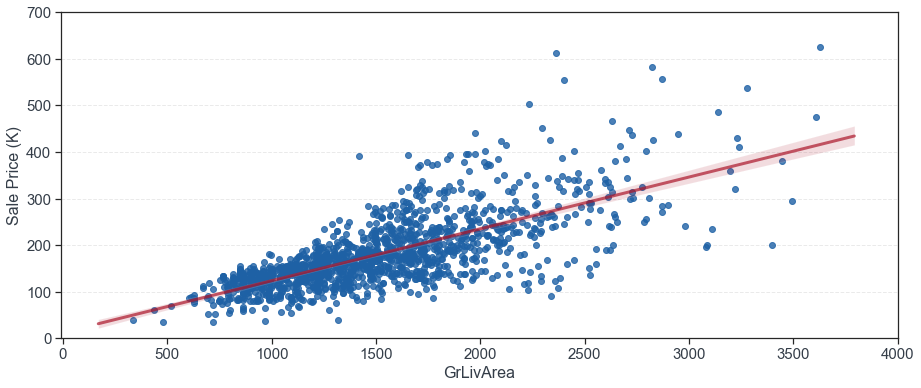

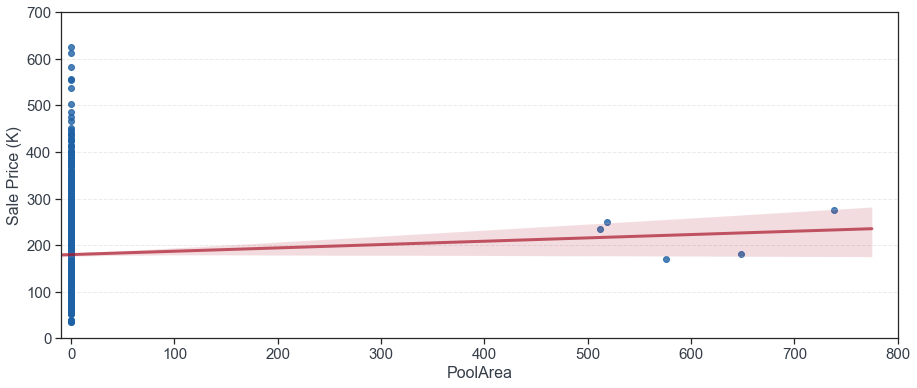

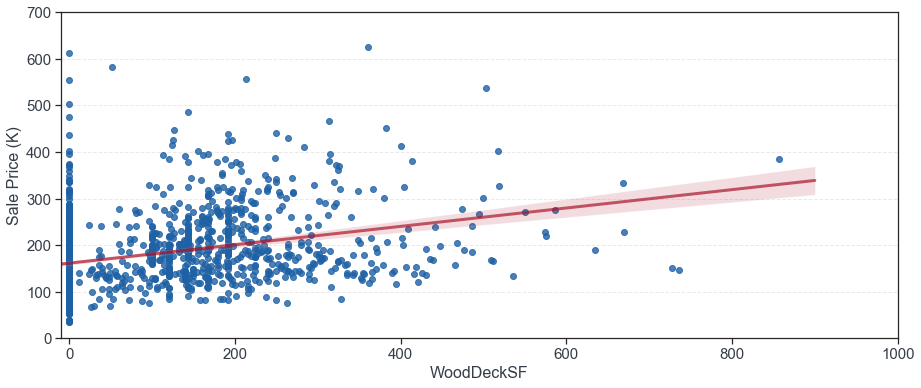

In [24]:
scatterplotpresentation(['GrLivArea', 'PoolArea', 'WoodDeckSF'])

In [25]:
def scatterplot (features):
    
    for elem in features:
   
        plt.figure(figsize = (14,7))
        sns.set(style="ticks", color_codes=True)
        sns.regplot(df_train[elem], df_train["SalePrice"],
                    color = [0.7622812227381776, 0.8406850963511671, 0.6846482959871109],
                    line_kws={"color":"darkgreen","alpha":0.7,"lw":3})
        plt.grid(b = True, which = 'major', color = '#999999', linestyle = '--', alpha = 0.2, axis = "y")
        plt.show()
        

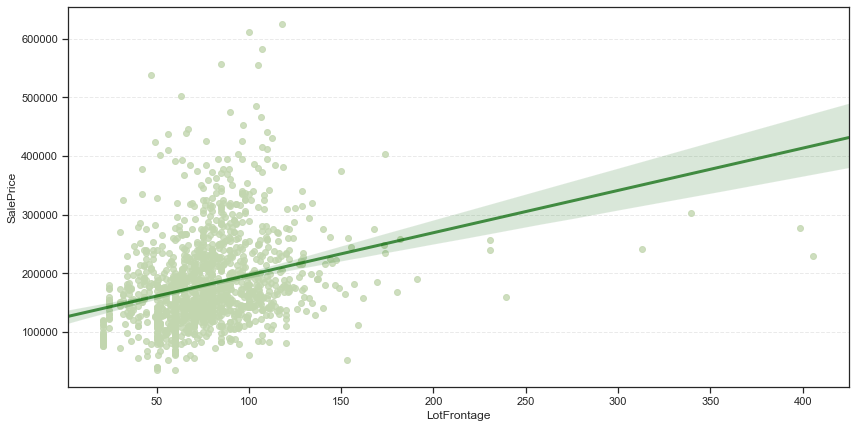

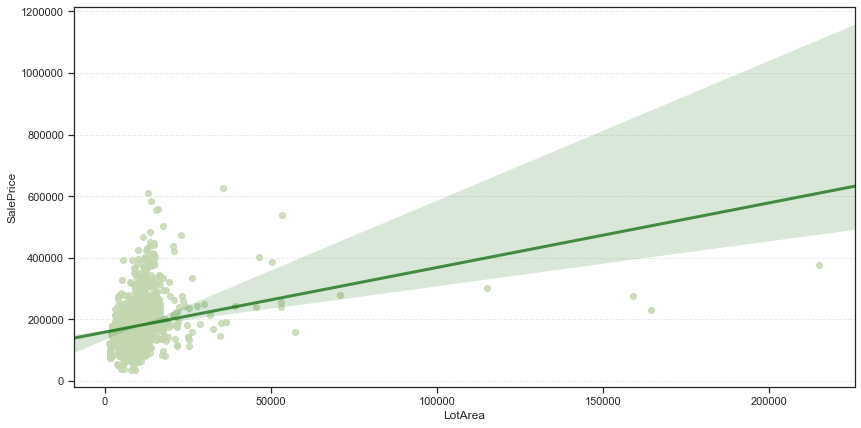

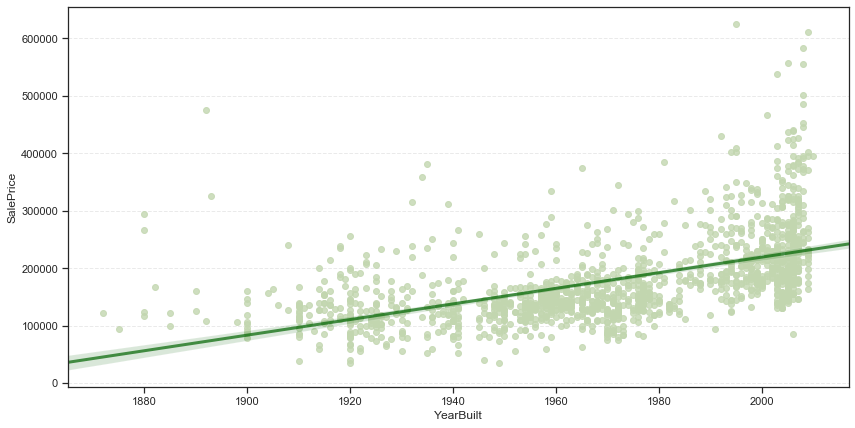

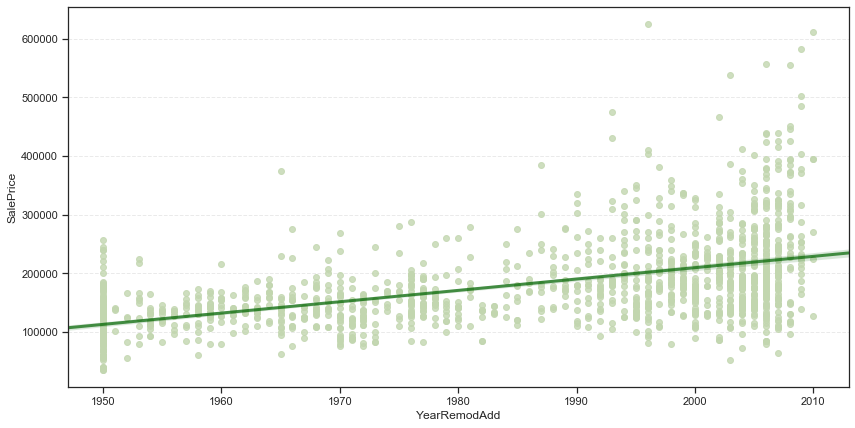

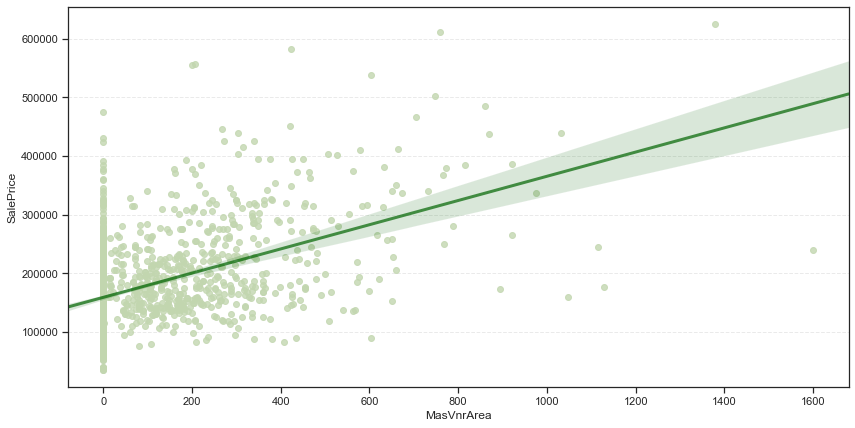

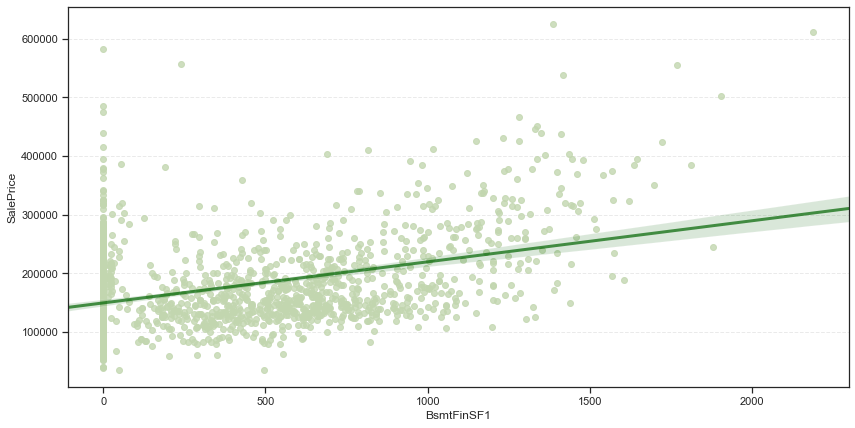

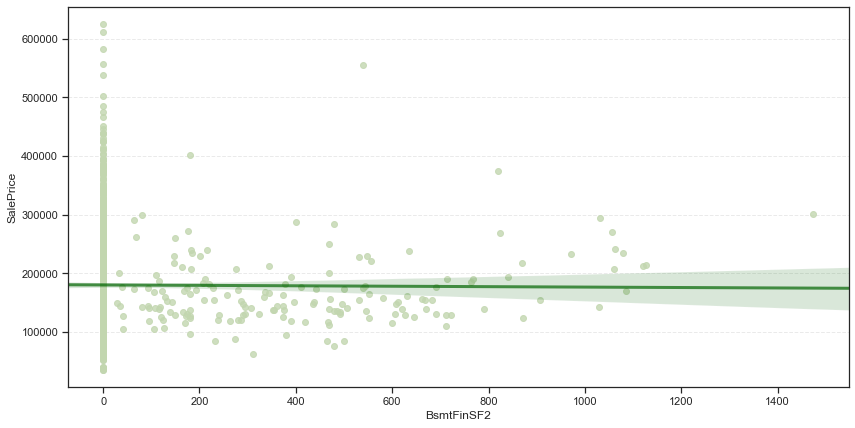

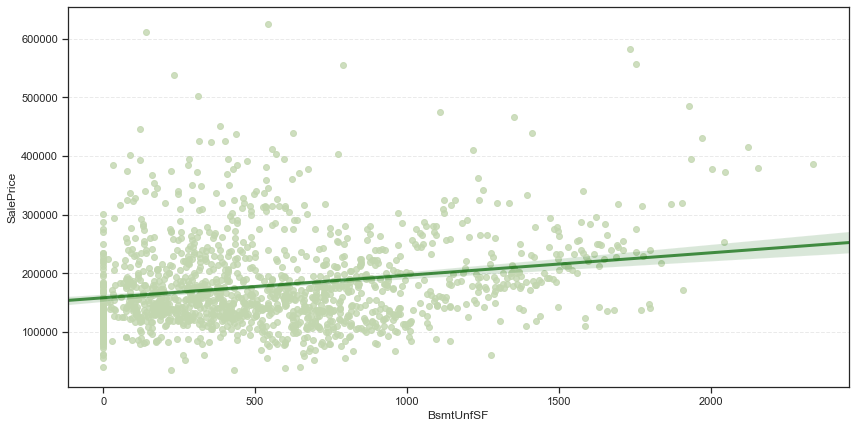

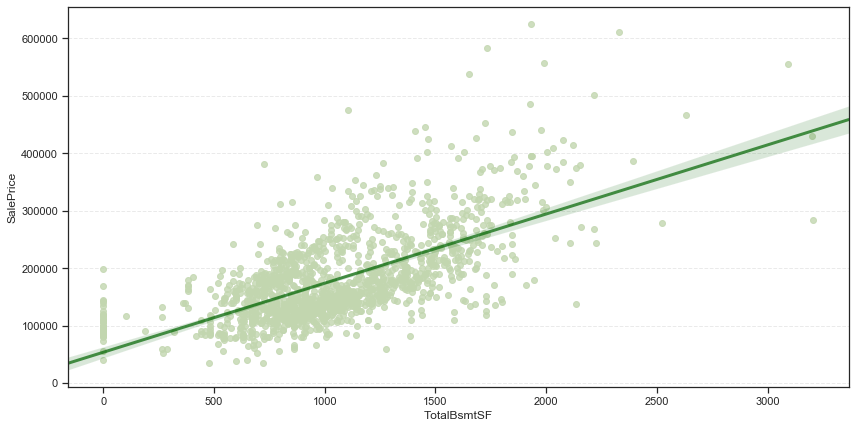

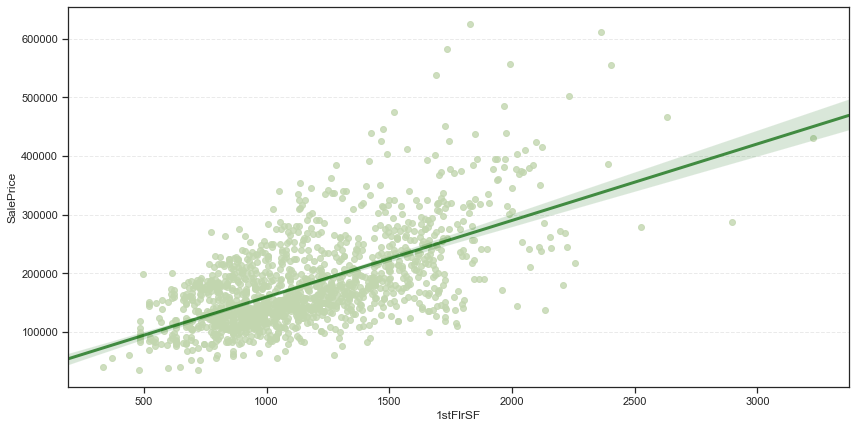

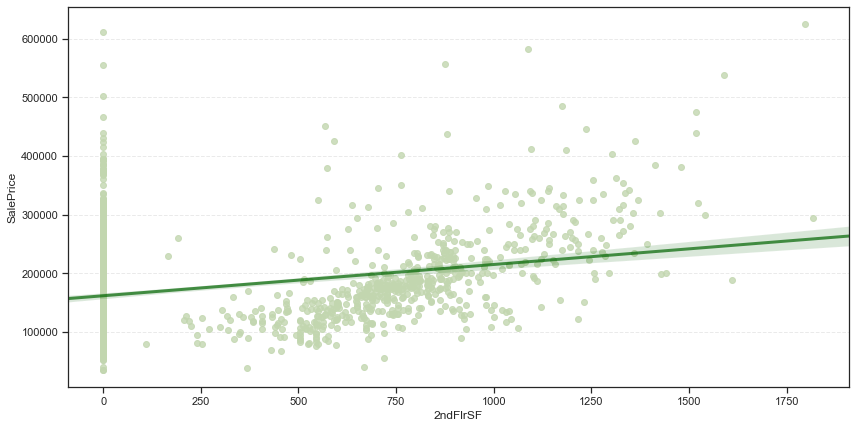

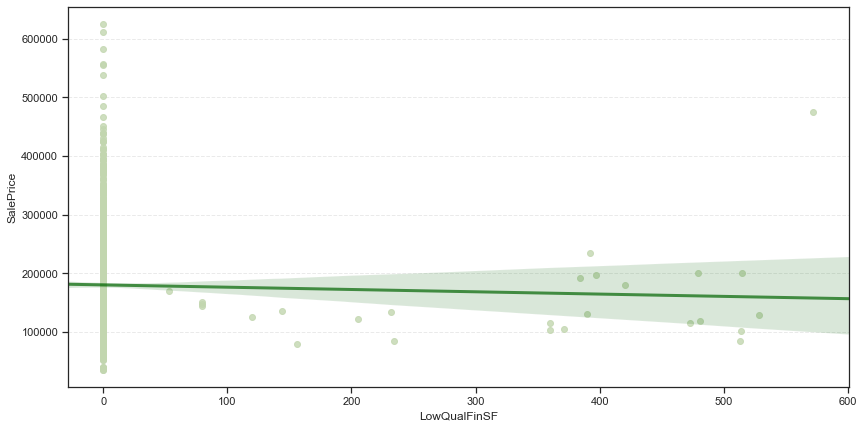

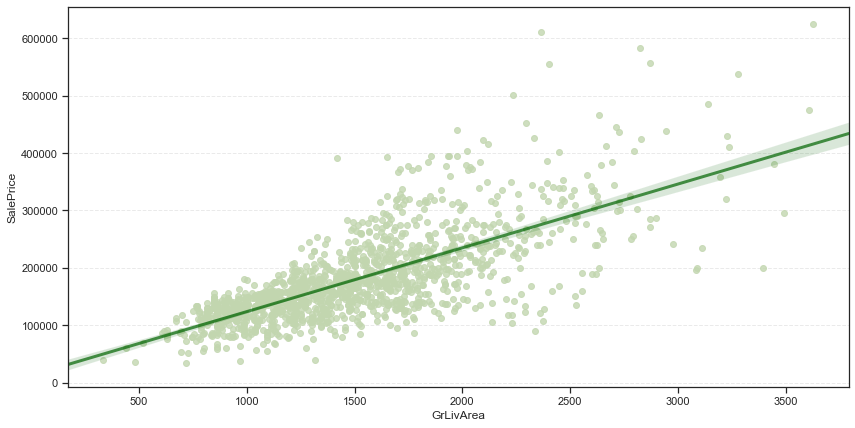

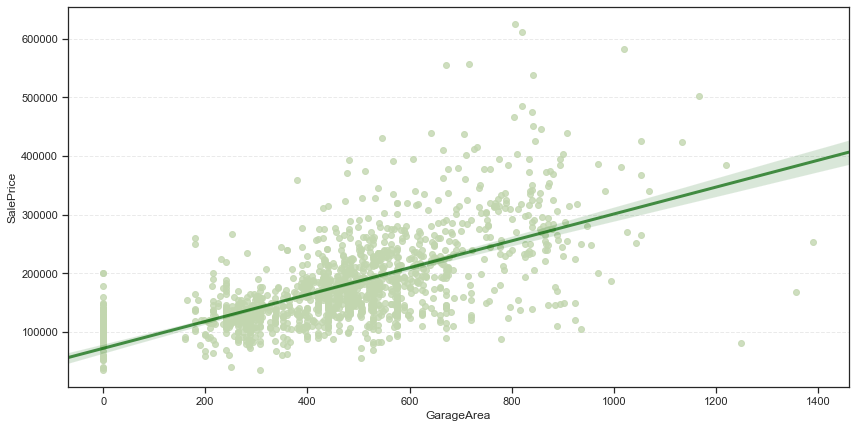

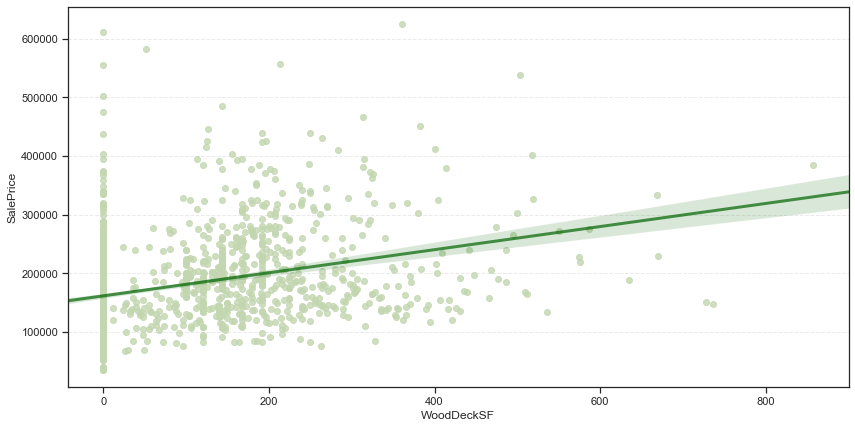

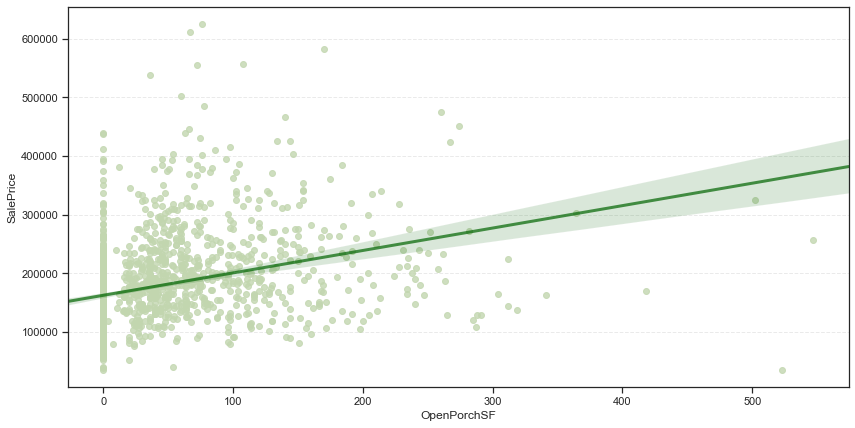

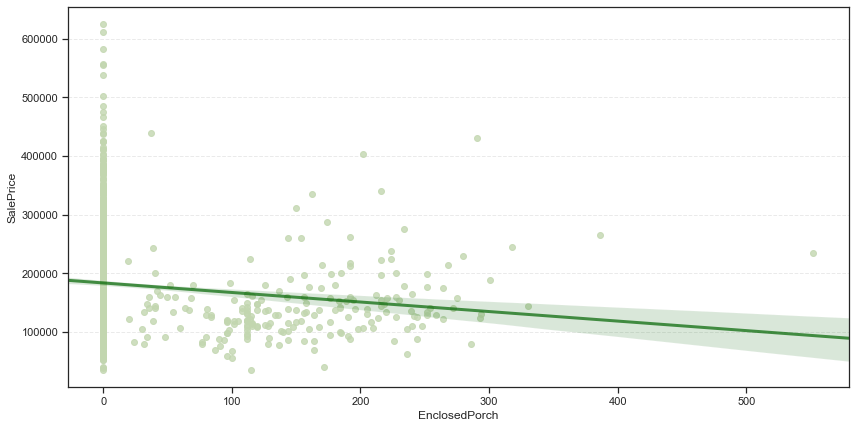

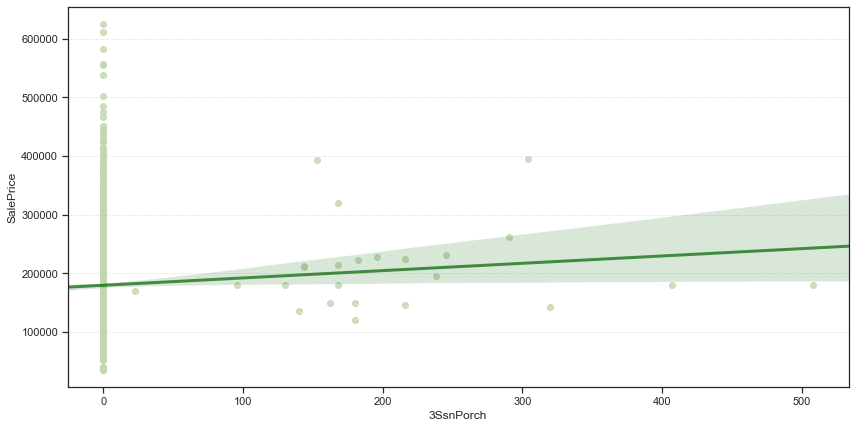

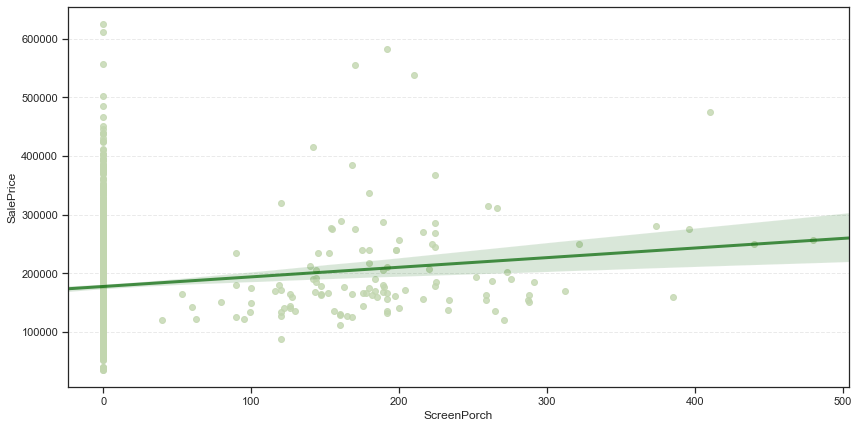

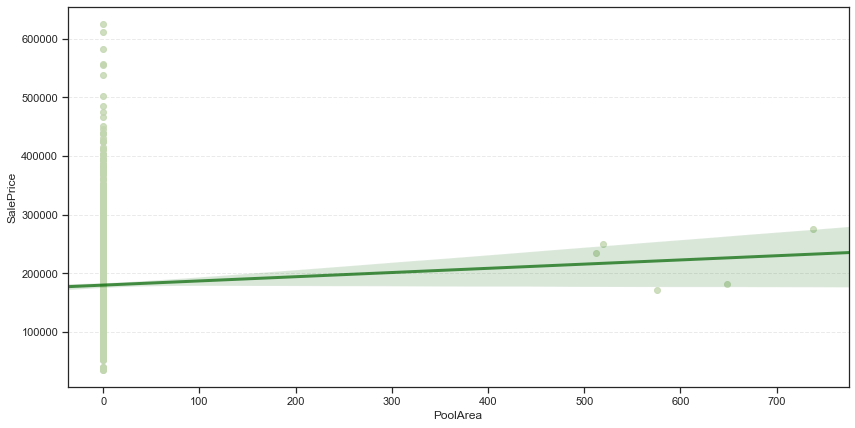

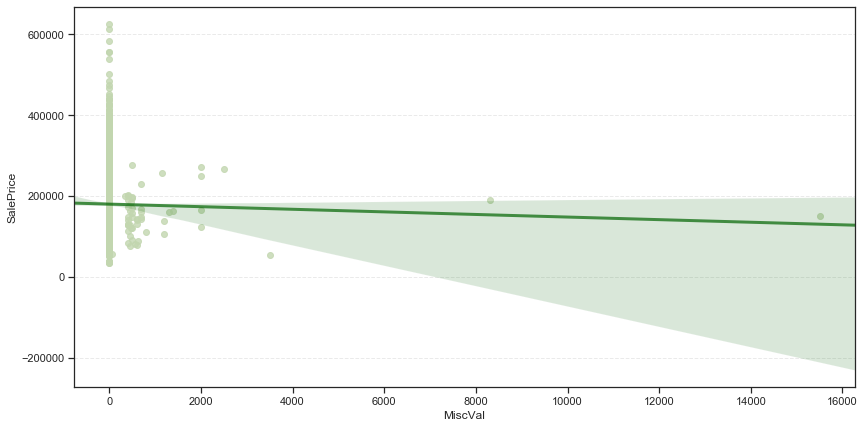

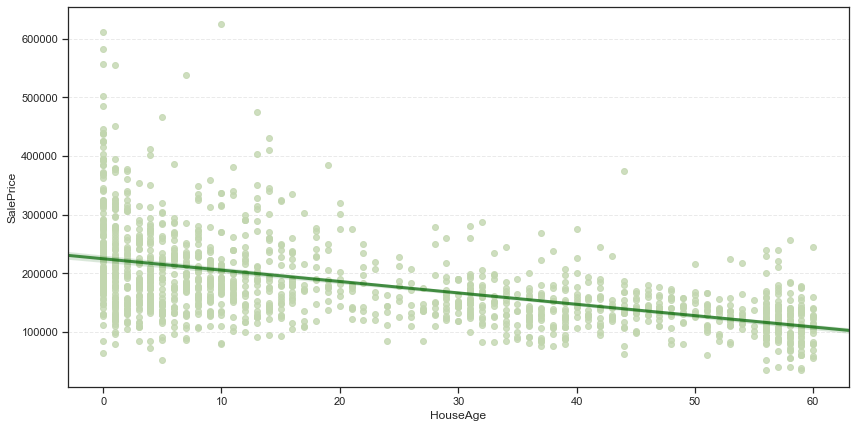

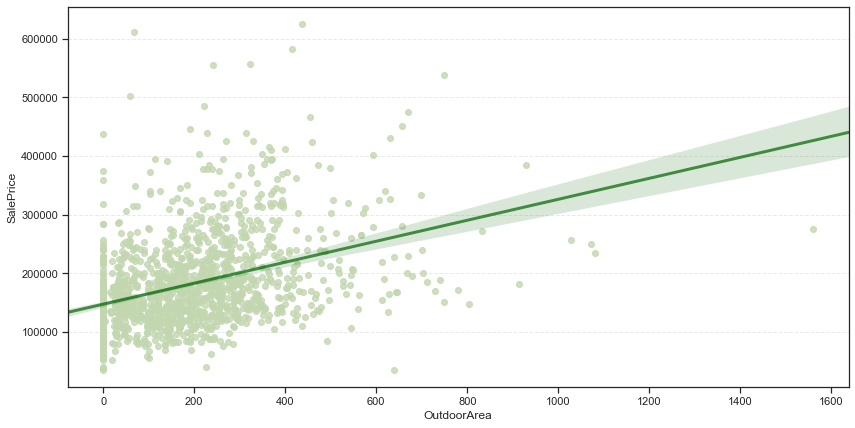

In [26]:
continuous_feature = [
#  'Id',
#  'MSSubClass',
#  'MSZoning',
'LotFrontage',
'LotArea',
#  'Street',
#  'Alley',
#  'LotShape',
#  'LandContour',
#  'Utilities',
#  'LotConfig',
#  'LandSlope',
#  'Neighborhood',
#  'Condition1',
#  'Condition2',
#  'BldgType',
#  'HouseStyle',
#  'OverallQual',
#  'OverallCond',
'YearBuilt',
'YearRemodAdd',
#  'RoofStyle',
#  'RoofMatl',
#  'Exterior1st',
#  'Exterior2nd',
#  'MasVnrType',
'MasVnrArea',
#  'ExterQual',
#  'ExterCond',
#  'Foundation',
#  'BsmtQual',
#  'BsmtCond',
#  'BsmtExposure',
#  'BsmtFinType1',
'BsmtFinSF1',
#  'BsmtFinType2',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
#  'Heating',
#  'HeatingQC',
#  'CentralAir',
#  'Electrical',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
#  'BsmtFullBath',
#  'BsmtHalfBath',
#  'FullBath',
#  'HalfBath',
#  'BedroomAbvGr',
#  'KitchenAbvGr',
#  'KitchenQual',
#  'TotRmsAbvGrd',
#  'Functional',
#  'Fireplaces',
#  'FireplaceQu',
#  'GarageType',
#'GarageYrBlt',
#  'GarageFinish',
#  'GarageCars',
'GarageArea',
#  'GarageQual',
#  'GarageCond',
#  'PavedDrive',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
#  'PoolQC',
#  'Fence',
#  'MiscFeature',
'MiscVal',
#  'MoSold',
#  'YrSold',
#  'SaleType',
#  'SaleCondition',
'HouseAge',
'OutdoorArea']
#'TotalBath',
#'LotShapeBin',
#'PoolBin',
#'FireplacesBin'




scatterplot(continuous_feature)

#  Testing for Multicollinearity - Continuous Variables

In [27]:
selected_continuous = ['Id',
                       #'SalePrice',
                       'LotFrontage',
                       'LotArea',
                       #'YearBuilt',
                       #'YearRemodAdd',
                       #'MasVnrArea',
                       #'BsmtFinSF1',
                       #'BsmtFinSF2',
                       #'BsmtUnfSF',
                       'TotalBsmtSF',
                       #'1stFlrSF',
                       #'2ndFlrSF',
                       #'LowQualFinSF',
                       'GrLivArea',
                       #'GarageYrBlt',
                       'GarageArea',
                       #'WoodDeckSF',
                       #'OpenPorchSF',
                       #'EnclosedPorch',
                       #'3SsnPorch',
                       #'ScreenPorch',
                       #'PoolArea',
                       #'MiscVal',
                       #'SaleCondition',
                       'HouseAge',
                       'OutdoorArea',
                       'Vintage'
                      ]


In [28]:
df1 = df_train[selected_continuous]

scores = {}
ols = linear_model.LinearRegression()

for feature_name in selected_continuous[1:]:
                df2     = df1.copy()
                feature = df2[feature_name].copy()
                df2.drop(feature_name, axis=1, inplace=True)
                ols.fit(df2, feature)
                scores[feature_name] = ols.score(df2, feature) 

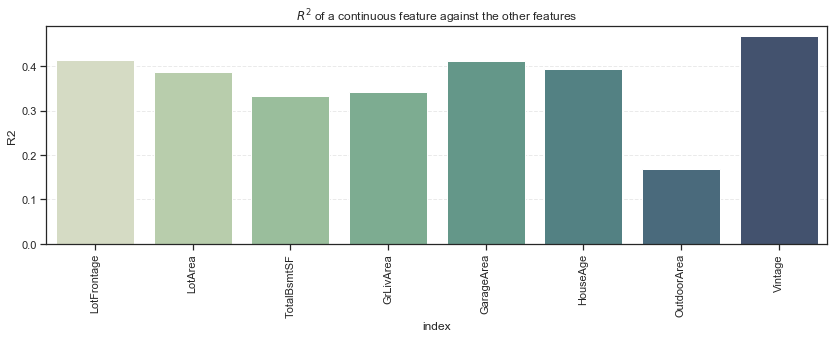

In [29]:
plt.figure(figsize = (14, 4))
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index(),
            palette = sns.cubehelix_palette(10, start=.5, rot=-.75))
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation=90)
plt.grid(b = True, which = 'major', color = '#999999', linestyle = '--', alpha = 0.2, axis = "y")

# Check for Normality

<Figure size 864x1152 with 0 Axes>

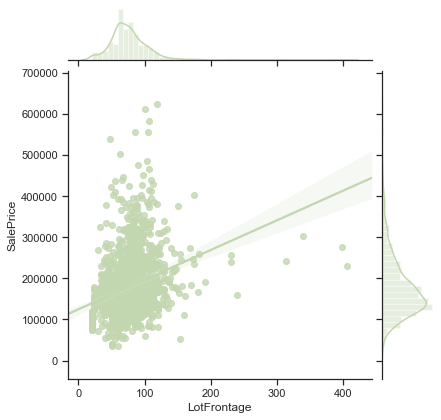

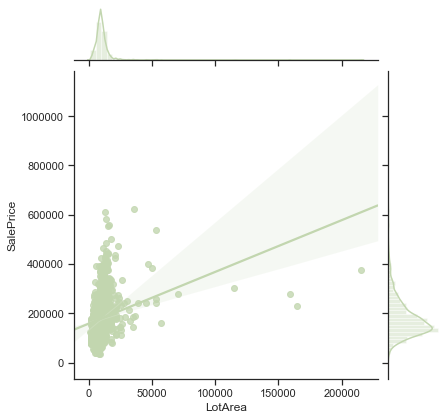

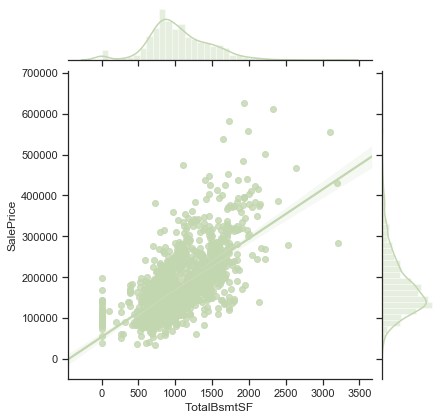

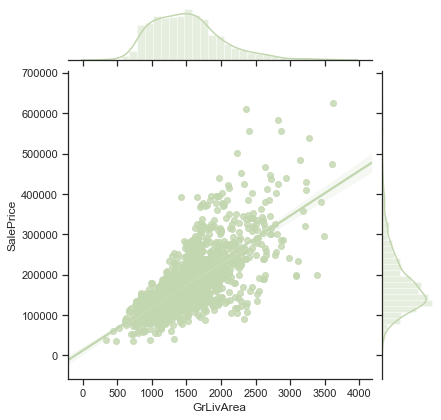

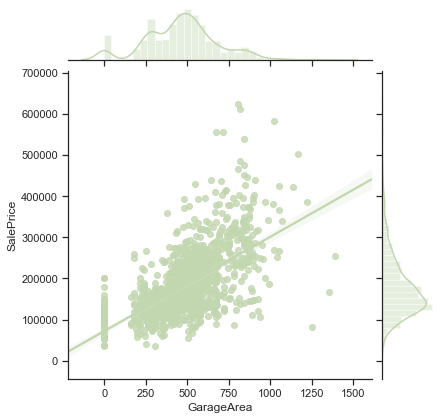

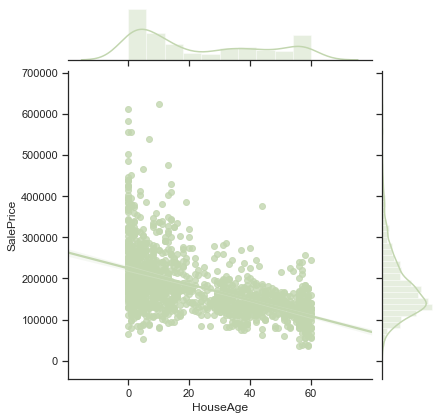

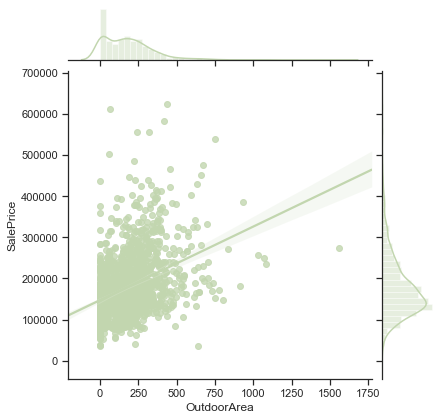

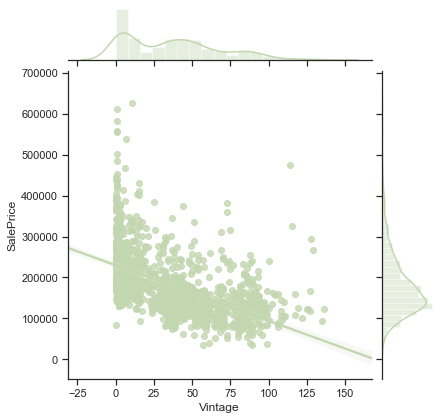

In [30]:
i = 0
plt.figure(figsize = (12,16))
color = sns.cubehelix_palette(10, start=.5, rot=-.75)

for elem in selected_continuous[1:]:
    
    #plt.subplot(i)
    sns.jointplot(df_train[elem], df_train['SalePrice'], kind = 'reg',
                  color = [0.7622812227381776, 0.8406850963511671, 0.6846482959871109])
    i = i + 1

plt.show()

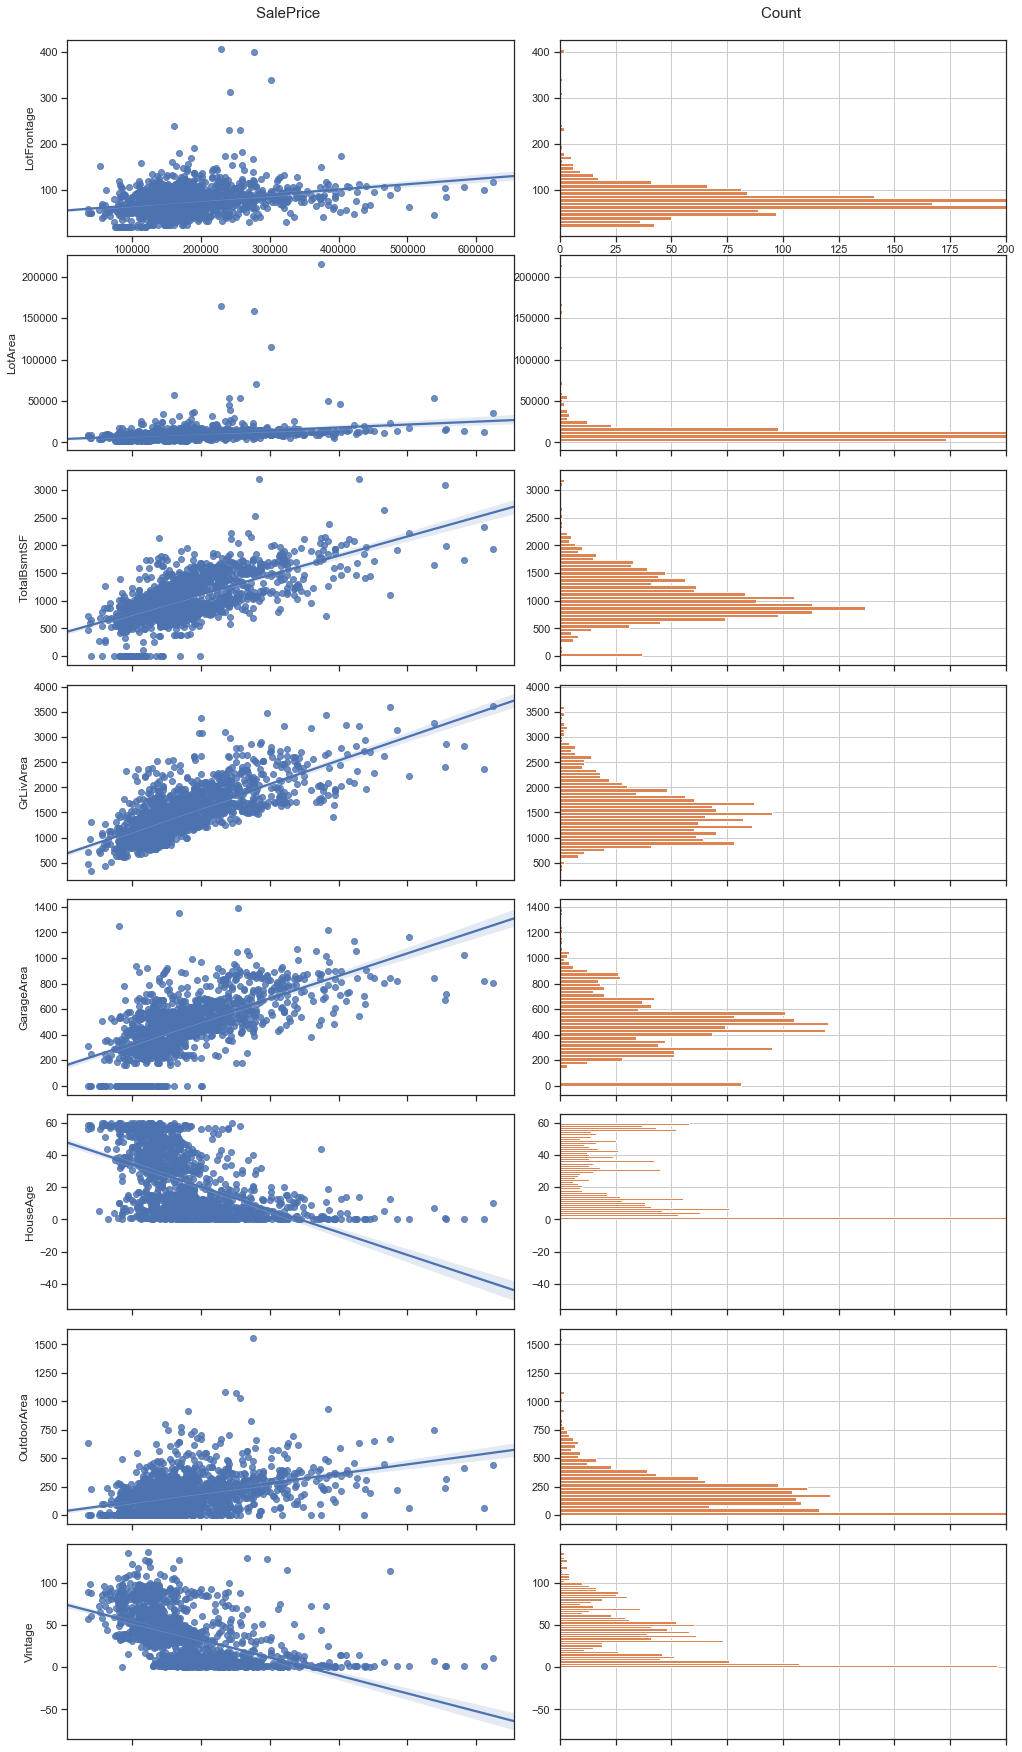

In [31]:
X_1 = df_train[selected_continuous[1:]]

fig = plt.figure(figsize=(14, 33))
gs = gridspec.GridSpec(11, 2)

for i in range(len(selected_continuous[1:])):
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])    
    sns.regplot(df_train["SalePrice"], X_1.iloc[:, i], ax=ax1)
    ax1.set_title('')
    ax1.set_xlabel('')
    ylim = ax1.get_ylim()   
    X_1[X_1.columns[i]].hist(bins=50, ax=ax2, orientation='horizontal')    
    ax2.set_ylim((ylim[0], ylim[1]))
    ax2.set_xlabel('')
    ax2.set_xlim((0, 200))
    for tick in ax2.yaxis.get_major_ticks():
        tick.label1.set_visible = False
        tick.label2.set_visible = True
    if i != 0:
        ax1.set_xticklabels([''])
        ax2.set_xticklabels([''])
    else:
        ax1.set_title('SalePrice \n', size=15)
        ax2.set_title('Count \n', size=15)
        for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_visible = False
            tick.label2.set_visible = True
        for tick in ax2.xaxis.get_major_ticks():
            tick.label1.set_visible = False
            tick.label2.set_visible = True
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()